# Blood Cell Image Health Classifier

- **Questions**: [Here](../data/exercise_2/HW2.pdf)
- **Answer Set**: No. 02
- **Full Name**: Mohammad Hosein Nemati
- **Student Code**: `610300185`

---

## Basics

In this section we will done some basic steps:

### Libraries

Before begin, we must import these required libraries:

In [119]:
import warnings

import cv2 as cv
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt

import sklearn.base as skbase
import sklearn.utils as skutils
import sklearn.metrics as skmetrics
import sklearn.pipeline as skpipeline
import sklearn.preprocessing as skprocessing
import sklearn.model_selection as skselection

import sklearn.svm as sksvm
import sklearn.tree as sktree
import sklearn.ensemble as skensemble
import sklearn.neighbors as skneighbors
import sklearn.neural_network as sknetwork

import scikeras.wrappers as scikeras

warnings.filterwarnings("ignore", category=UserWarning)
sk.set_config(display="diagram")

### Dataset

Now we can load our dataset:

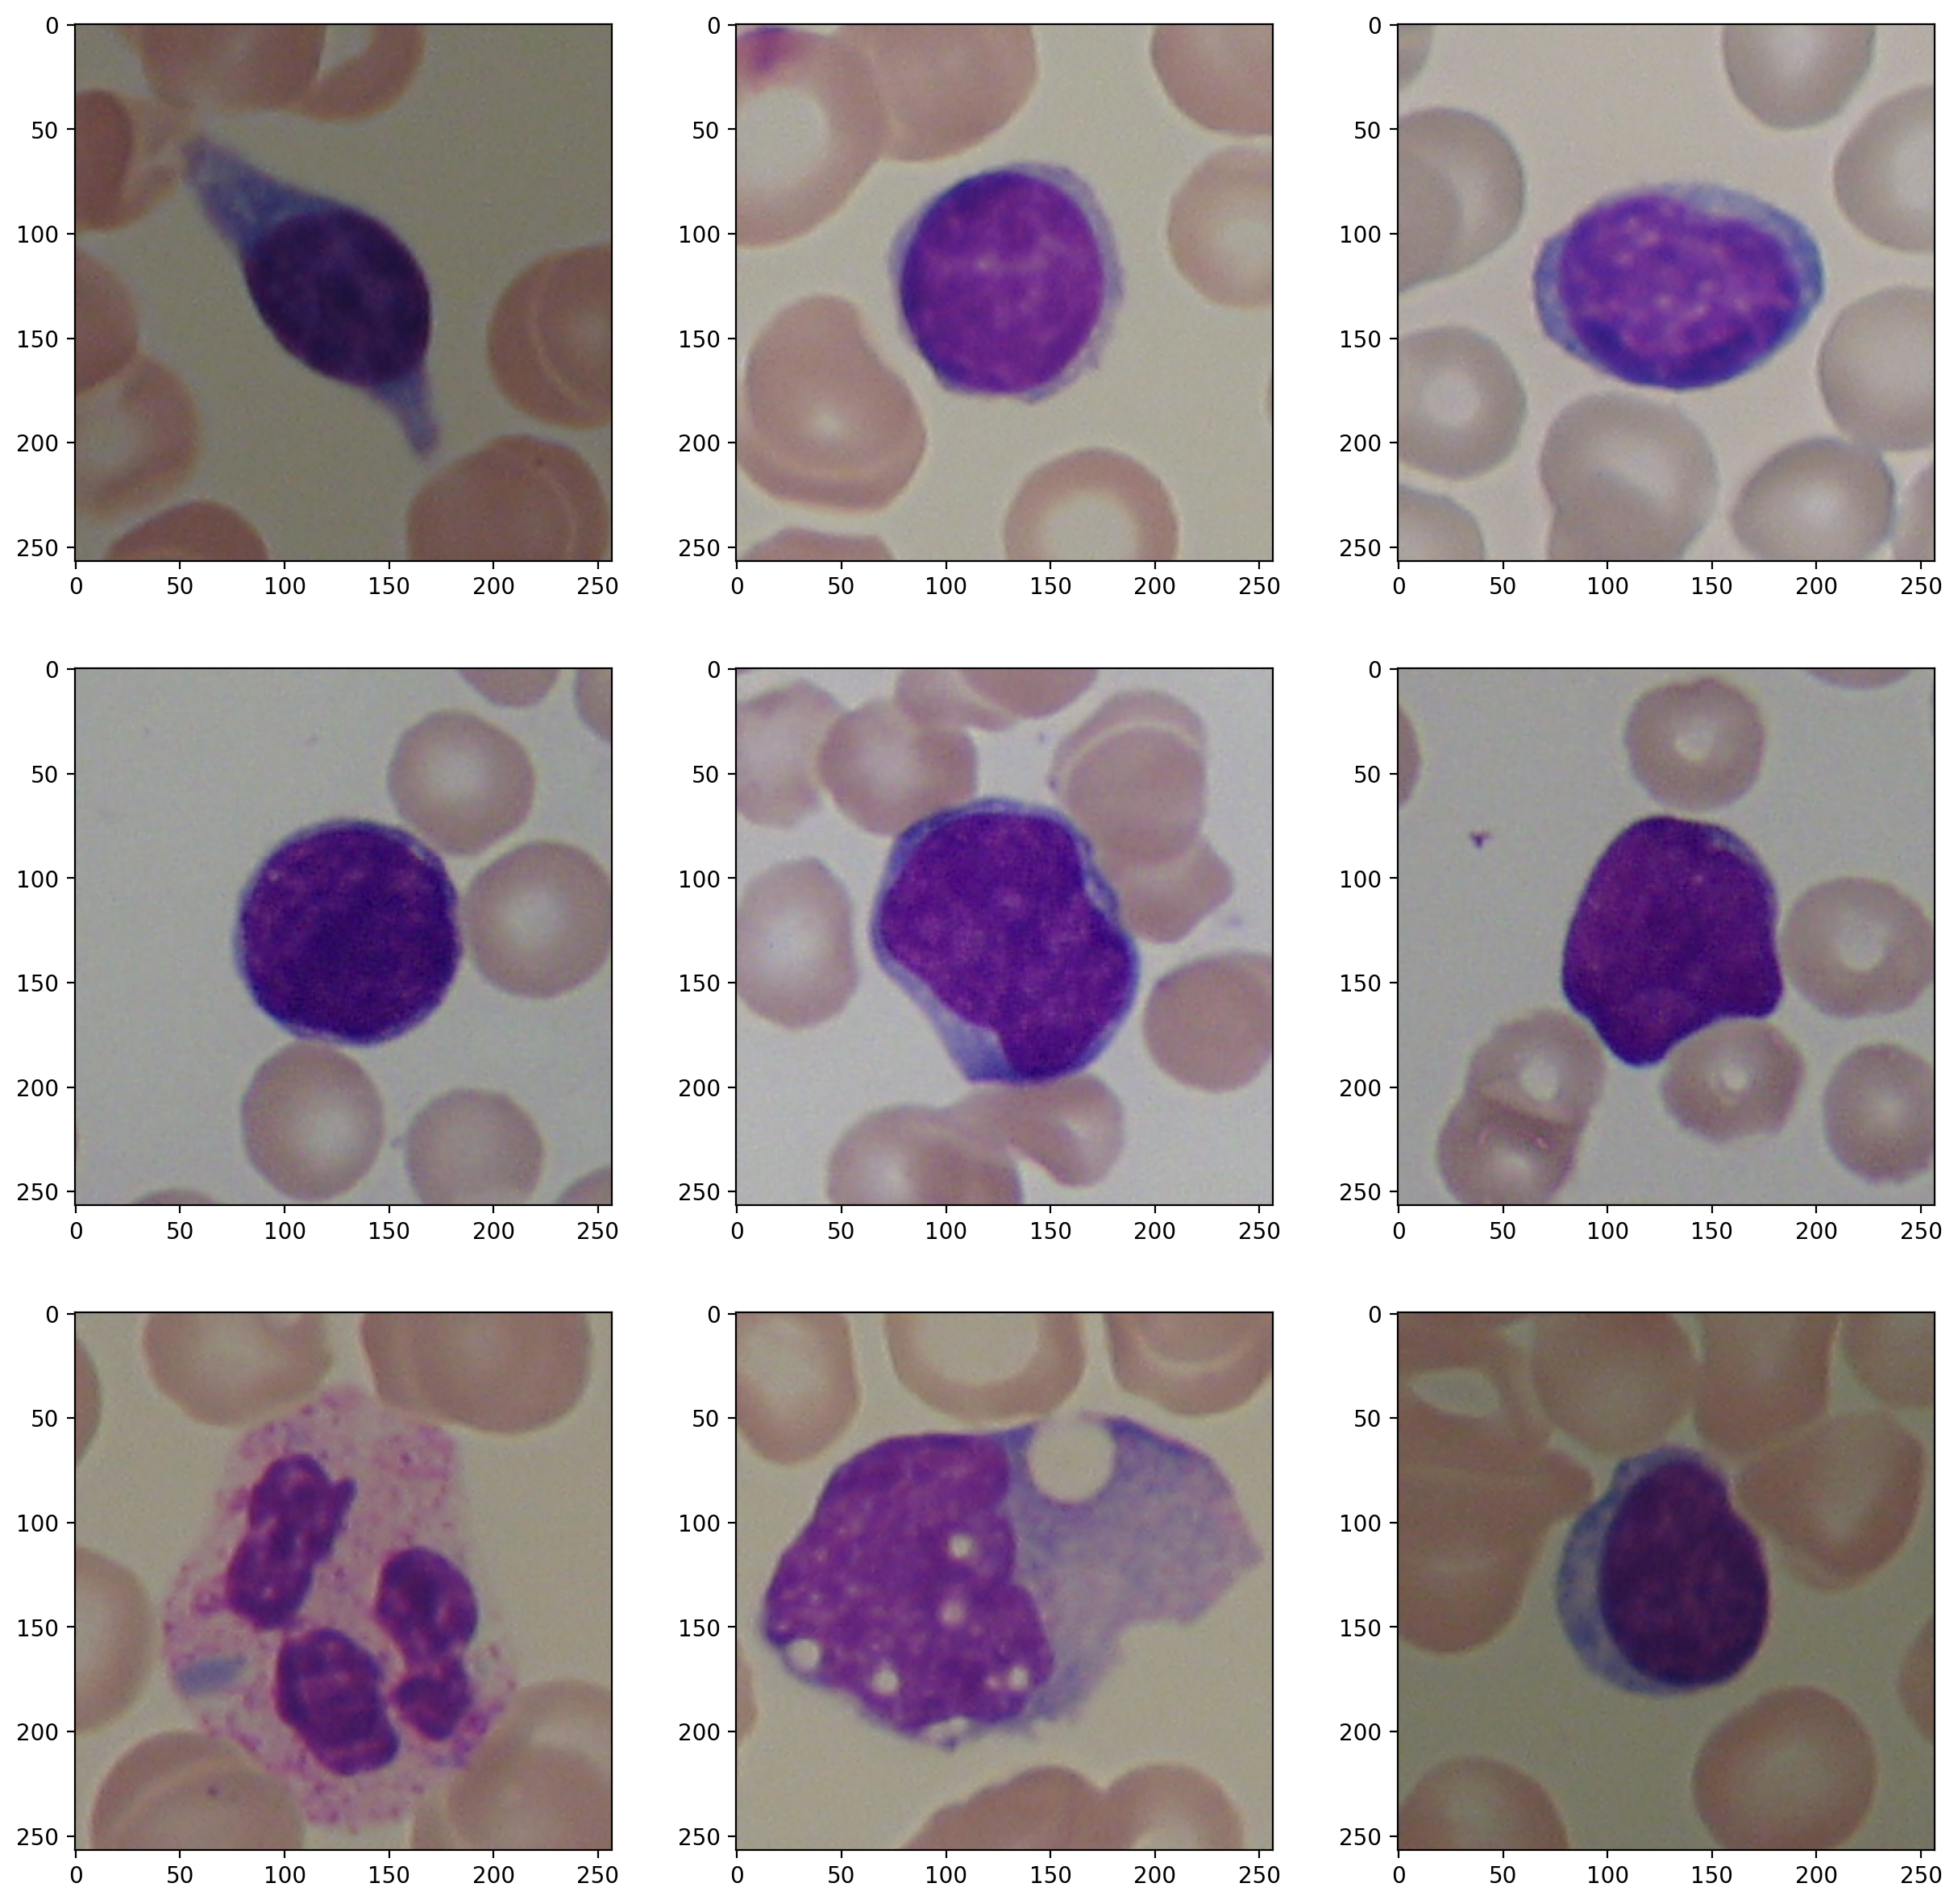

In [120]:
import os

def imread(path):
    img = cv.imread(path)
    img = cv.resize(img, (257 , 257))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return tf.convert_to_tensor(img)

data_set = [
    (
        imread(f"../lib/ALL_IDB2/img/{f}"), 
        0 if "_0.tif" in f else 1
    ) 
    for f in os.listdir("../lib/ALL_IDB2/img")
]
np.random.shuffle(data_set)

data_features, data_labels = zip(*data_set)

train_features, test_features, train_labels, test_labels = skselection.train_test_split(
    data_features, 
    data_labels, 
    test_size=0.3, 
    random_state=313
)

train_features = tf.convert_to_tensor(train_features)
test_features = tf.convert_to_tensor(test_features)
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

fig, plots = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), dpi=200)
plots = plots.flatten()
for i in range(9):
    plots[i].imshow(train_features[i])

plt.show()

---

## Problem

First of all, we will train a **CNN** classifier, then we will drop the `Dense` layers and use the `Convolution` layers as a **Feature Extractor** for other classifiers

In [121]:
class CNNTransformer(skbase.TransformerMixin):
    def __init__(self):
        super().__init__()

        self.model_ = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(257, 257, 3)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
        ])

        self.classifier_ = tf.keras.models.Sequential([
            self.model_,
            tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="linear"),
        ])

        self.classifier_.compile(loss="squared_hinge", optimizer="adam", metrics=["accuracy"])
        self.is_fitted = False
        
    def fit(self, X, y):
        if not self.is_fitted:
            self.classifier_.fit(X, y, epochs=15)
            self.is_fitted = True

        return self

    def transform(self, X):
        return self.model_.predict(X)

cnn_model = CNNTransformer().fit(train_features, train_labels)

Epoch 1/15
6/6 [==============================] - 15s 2s/step - loss: 1326990.1250 - accuracy: 0.4670
Epoch 2/15
6/6 [==============================] - 14s 2s/step - loss: 1550.1023 - accuracy: 0.5110
Epoch 3/15
6/6 [==============================] - 14s 2s/step - loss: 178.4975 - accuracy: 0.4945
Epoch 4/15
6/6 [==============================] - 14s 2s/step - loss: 3.9251 - accuracy: 0.7308
Epoch 5/15
6/6 [==============================] - 14s 2s/step - loss: 3.4005 - accuracy: 0.6978
Epoch 6/15
6/6 [==============================] - 14s 2s/step - loss: 0.8551 - accuracy: 0.7747
Epoch 7/15
6/6 [==============================] - 14s 2s/step - loss: 0.5270 - accuracy: 0.7802
Epoch 8/15
6/6 [==============================] - 14s 2s/step - loss: 0.4876 - accuracy: 0.8132
Epoch 9/15
6/6 [==============================] - 14s 2s/step - loss: 0.3778 - accuracy: 0.8022
Epoch 10/15
6/6 [==============================] - 14s 2s/step - loss: 0.3397 - accuracy: 0.8077
Epoch 11/15
6/6 [===========

### CNN + Decision Tree

In this section, we will define a pipeline that first will **Transform** records using a `CNN`, then it will use `Decision Tree` model to classify records

In [122]:
dt_model = skpipeline.Pipeline([
    ("convolver", cnn_model),
    ("classifier", sktree.DecisionTreeClassifier())
]).fit(train_features, train_labels)

dt_predicts = dt_model.predict(test_features)

dt_model

3/3 [==============================] - 1s 442ms/step


Pipeline(steps=[('convolver',
                 <__main__.CNNTransformer object at 0x000002C61FD926D0>),
                ('classifier', DecisionTreeClassifier())])

### CNN + Random Forest

In this section, we will define a pipeline that first will **Transform** records using a `CNN`, then it will use `Random Forest` model to classify records

In [123]:
rf_model = skpipeline.Pipeline([
    ("convolver", cnn_model),
    ("classifier", skensemble.RandomForestClassifier())
]).fit(train_features, train_labels)

rf_predicts = rf_model.predict(test_features)

rf_model

3/3 [==============================] - 2s 431ms/step


Pipeline(steps=[('convolver',
                 <__main__.CNNTransformer object at 0x000002C61FD926D0>),
                ('classifier', RandomForestClassifier())])

### CNN + MLP

In this section, we will define a pipeline that first will **Transform** records using a `CNN`, then it will use `MLP` model to classify records

In [124]:
mlp_model = skpipeline.Pipeline([
    ("convolver", cnn_model),
    ("classifier", sknetwork.MLPClassifier())
]).fit(train_features, train_labels)

mlp_predicts = mlp_model.predict(test_features)

mlp_model

3/3 [==============================] - 2s 523ms/step


Pipeline(steps=[('convolver',
                 <__main__.CNNTransformer object at 0x000002C61FD926D0>),
                ('classifier', MLPClassifier())])

### CNN + KNN

In this section, we will define a pipeline that first will **Transform** records using a `CNN`, then it will use `KNN` model to classify records

In [125]:
knn_model = skpipeline.Pipeline([
    ("convolver", cnn_model),
    ("classifier", skneighbors.KNeighborsClassifier())
]).fit(train_features, train_labels)

knn_predicts = knn_model.predict(test_features)

knn_model

3/3 [==============================] - 2s 463ms/step


Pipeline(steps=[('convolver',
                 <__main__.CNNTransformer object at 0x000002C61FD926D0>),
                ('classifier', KNeighborsClassifier())])

### CNN + SVM

In this section, we will define a pipeline that first will **Transform** records using a `CNN`, then it will use `SVM` model to classify records

In [126]:
svm_model = skpipeline.Pipeline([
    ("convolver", cnn_model),
    ("classifier", sksvm.SVC())
]).fit(train_features, train_labels)

svm_predicts = svm_model.predict(test_features)

svm_model

3/3 [==============================] - 2s 450ms/step


Pipeline(steps=[('convolver',
                 <__main__.CNNTransformer object at 0x000002C61FD926D0>),
                ('classifier', SVC())])

### Results

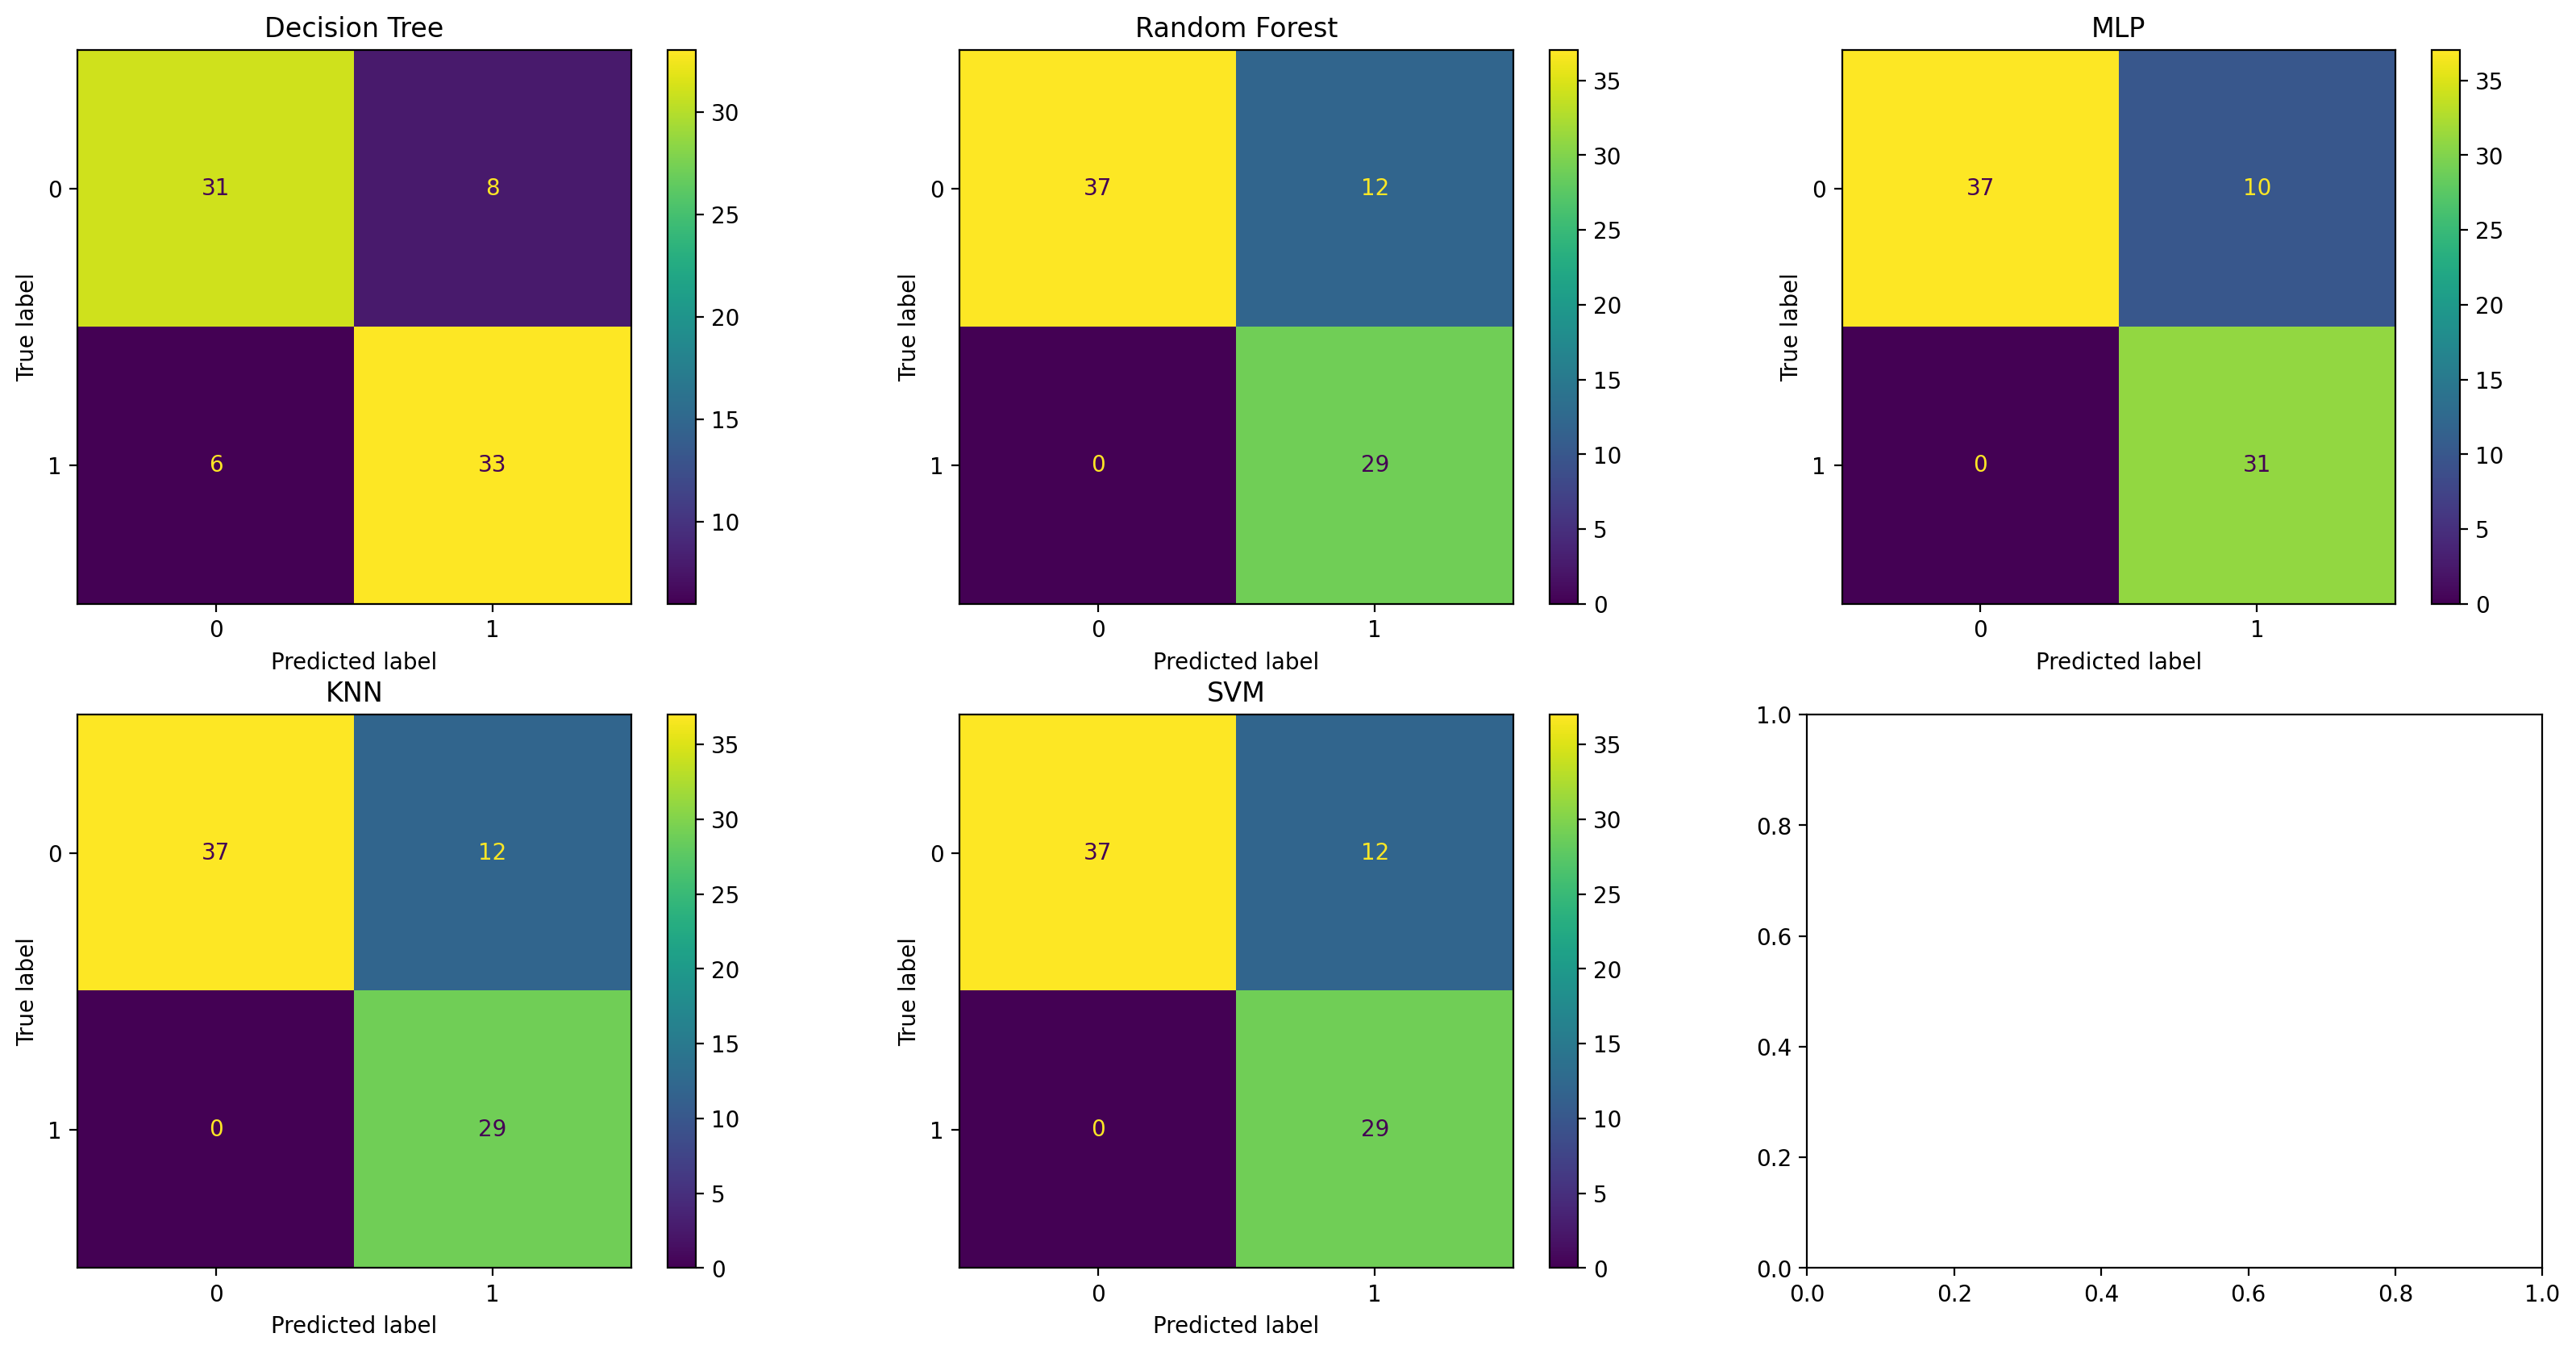

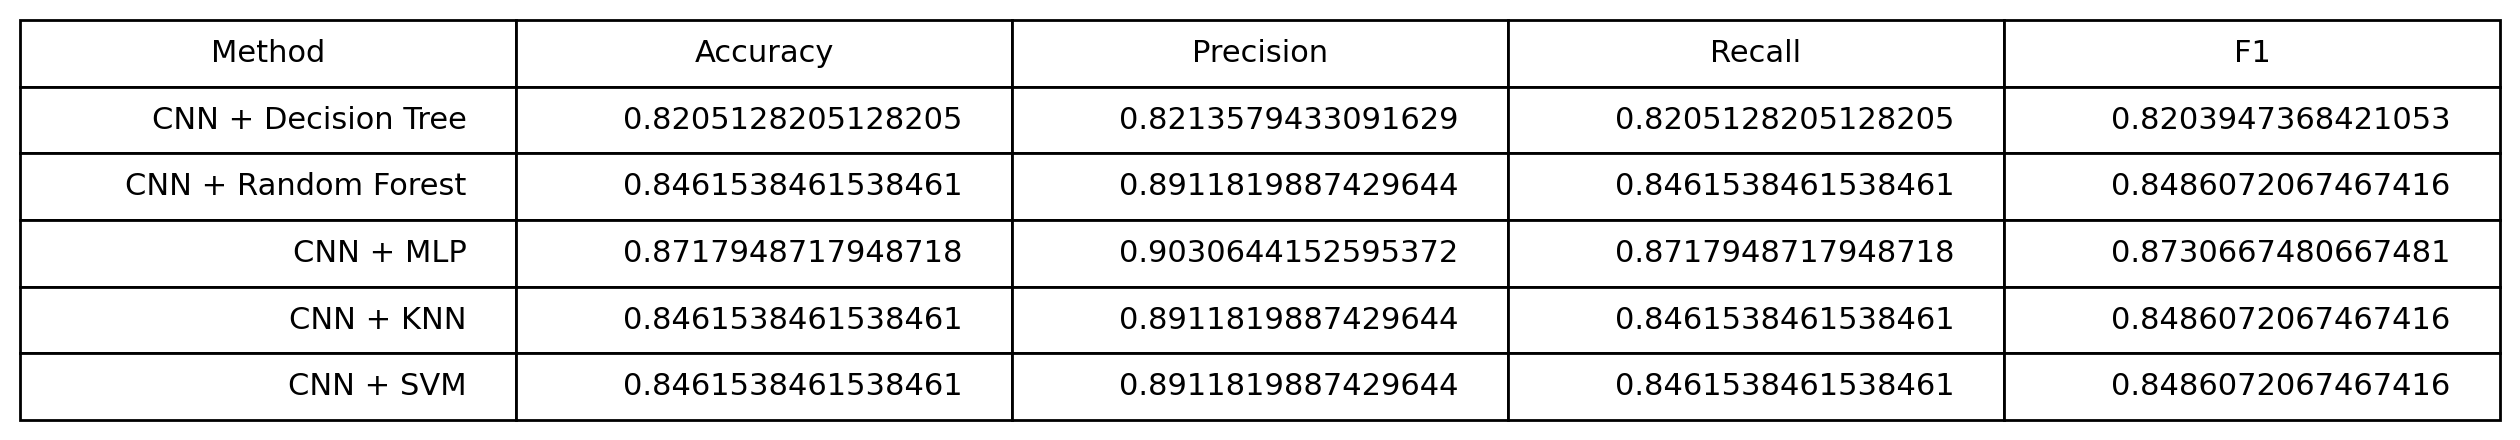

In [127]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10), dpi=200)
axes = axes.flatten()

axes[0].set_title("Decision Tree")
skmetrics.ConfusionMatrixDisplay.from_predictions(
    dt_predicts,
    test_labels,
    ax=axes[0]
)

axes[1].set_title("Random Forest")
skmetrics.ConfusionMatrixDisplay.from_predictions(
    rf_predicts,
    test_labels,
    ax=axes[1]
)

axes[2].set_title("MLP")
skmetrics.ConfusionMatrixDisplay.from_predictions(
    mlp_predicts,
    test_labels,
    ax=axes[2]
)

axes[3].set_title("KNN")
skmetrics.ConfusionMatrixDisplay.from_predictions(
    knn_predicts,
    test_labels,
    ax=axes[3]
)

axes[4].set_title("SVM")
skmetrics.ConfusionMatrixDisplay.from_predictions(
    svm_predicts,
    test_labels,
    ax=axes[4]
)

plt.show()

plt.figure(figsize=(8, 1), dpi=200)
table = plt.table(cellText=[
    [
        "CNN + Decision Tree",
        skmetrics.accuracy_score(dt_predicts, test_labels),
        skmetrics.precision_score(dt_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.recall_score(dt_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.f1_score(dt_predicts, test_labels, average="weighted", zero_division=True)
    ],
    [
        "CNN + Random Forest",
        skmetrics.accuracy_score(rf_predicts, test_labels),
        skmetrics.precision_score(rf_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.recall_score(rf_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.f1_score(rf_predicts, test_labels, average="weighted", zero_division=True)
    ],
    [
        "CNN + MLP",
        skmetrics.accuracy_score(mlp_predicts, test_labels),
        skmetrics.precision_score(mlp_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.recall_score(mlp_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.f1_score(mlp_predicts, test_labels, average="weighted", zero_division=True)
    ],
    [
        "CNN + KNN",
        skmetrics.accuracy_score(knn_predicts, test_labels),
        skmetrics.precision_score(knn_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.recall_score(knn_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.f1_score(knn_predicts, test_labels, average="weighted", zero_division=True)
    ],
    [
        "CNN + SVM",
        skmetrics.accuracy_score(svm_predicts, test_labels),
        skmetrics.precision_score(svm_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.recall_score(svm_predicts, test_labels, average="weighted", zero_division=True),
        skmetrics.f1_score(svm_predicts, test_labels, average="weighted", zero_division=True)
    ],
], colLabels=["Method", "Accuracy", "Precision", "Recall", "F1"], loc="center")
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(2, 2)
plt.axis("off")
plt.show()

---